In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import interpolate
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog

In [23]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

### Compare the richness-based cluster finder to their best-fit model $\Delta\Sigma$ profiles

#### DSigma profiles of HSC massive galaxies

In [24]:
# DeltaSigma profiles of HSC massive galaxies
topn_massive = pickle.load(open(os.path.join(res_dir, 'topn_galaxies_sum.pkl'), 'rb'))

# DeltaSigma profiles of redMaPPer and CAMIRA clusters
topn_cluster = pickle.load(open(os.path.join(res_dir, 'topn_clusters_cen_sum.pkl'), 'rb'))

# For clusters, but using both central and satellite galaxies
topn_cluster_all = pickle.load(open(os.path.join(res_dir, 'topn_clusters_sum.pkl'), 'rb'))

#### DSigma profiles of mock galaxies

In [25]:
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

#### Halo mass distributions

In [26]:
sim_mhalo = Table.read(os.path.join(sim_dir, 'sim_merge_mhalo_hist.fits'))

#### Compare to [50, 100] kpc outskirt mass 

<ipython-input-58-566934779293>:22: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


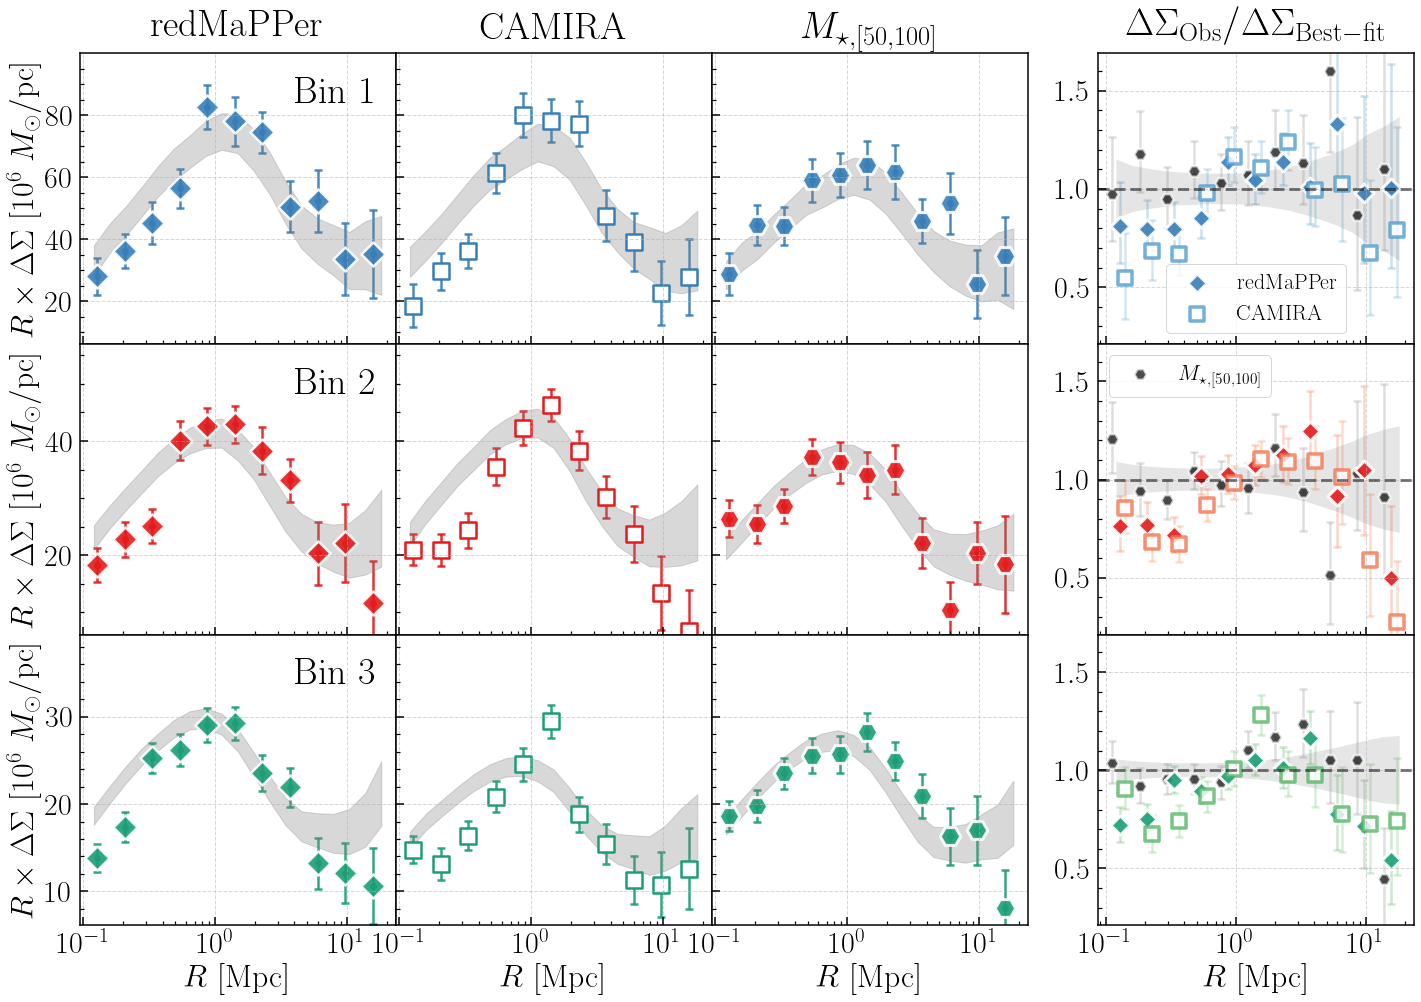

In [65]:
dsig_1 = topn_cluster['redm_hsc_lambda'][:3]
label_1 = r'$\rm redMaPPer$'
sub_1 = r'{\rm redM}'

dsig_2 = topn_cluster['cam_s16a_n_mem'][:3]
label_2 = r'$\rm CAMIRA$'
sub_2 = r'{\rm CAM}'

dsig_3 = topn_massive['logm_50_100'][:3]
label_3 = r'$M_{\star,\ [50, 100]}$'
sub_3 = r'{[50, 100]}'

fig = compare_richness_mstar_model(dsig_1, dsig_2, dsig_3, sim_dsig)

In [71]:
fig.savefig(os.path.join(fig_dir, 'fig_10.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_10.pdf'), dpi=120)

#### Impact of satellite galaxies

<ipython-input-58-566934779293>:22: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


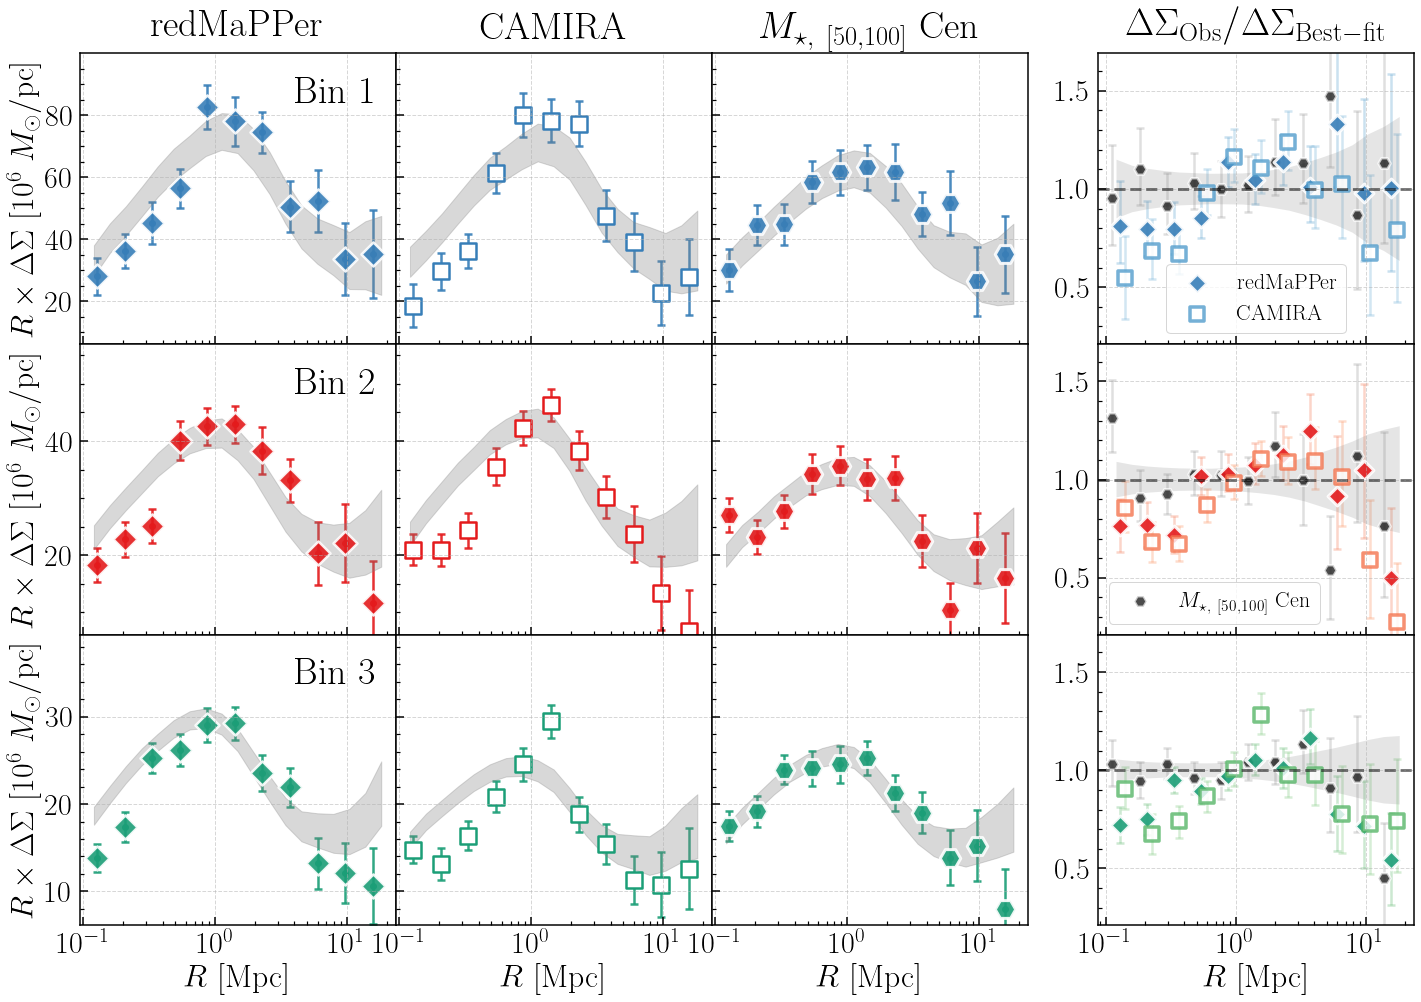

In [70]:
dsig_1 = topn_cluster['redm_hsc_lambda'][:3]
label_1 = r'$\rm redMaPPer$'
sub_1 = r'{\rm redM}'

dsig_2 = topn_cluster['cam_s16a_n_mem'][:3]
label_2 = r'$\rm CAMIRA$'
sub_2 = r'{\rm CAM}'

dsig_3 = topn_massive['logm_50_100_cen3'][:3]
label_3 = r'$M_{\star,\ [50, 100]}\ \rm Cen$'
sub_3 = r'{[50, 100]}'

fig = compare_richness_mstar_model(dsig_1, dsig_2, dsig_3, sim_dsig, label_3=label_3)

#### Compare with 100 kpc aperture stellar mass

<ipython-input-58-566934779293>:22: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


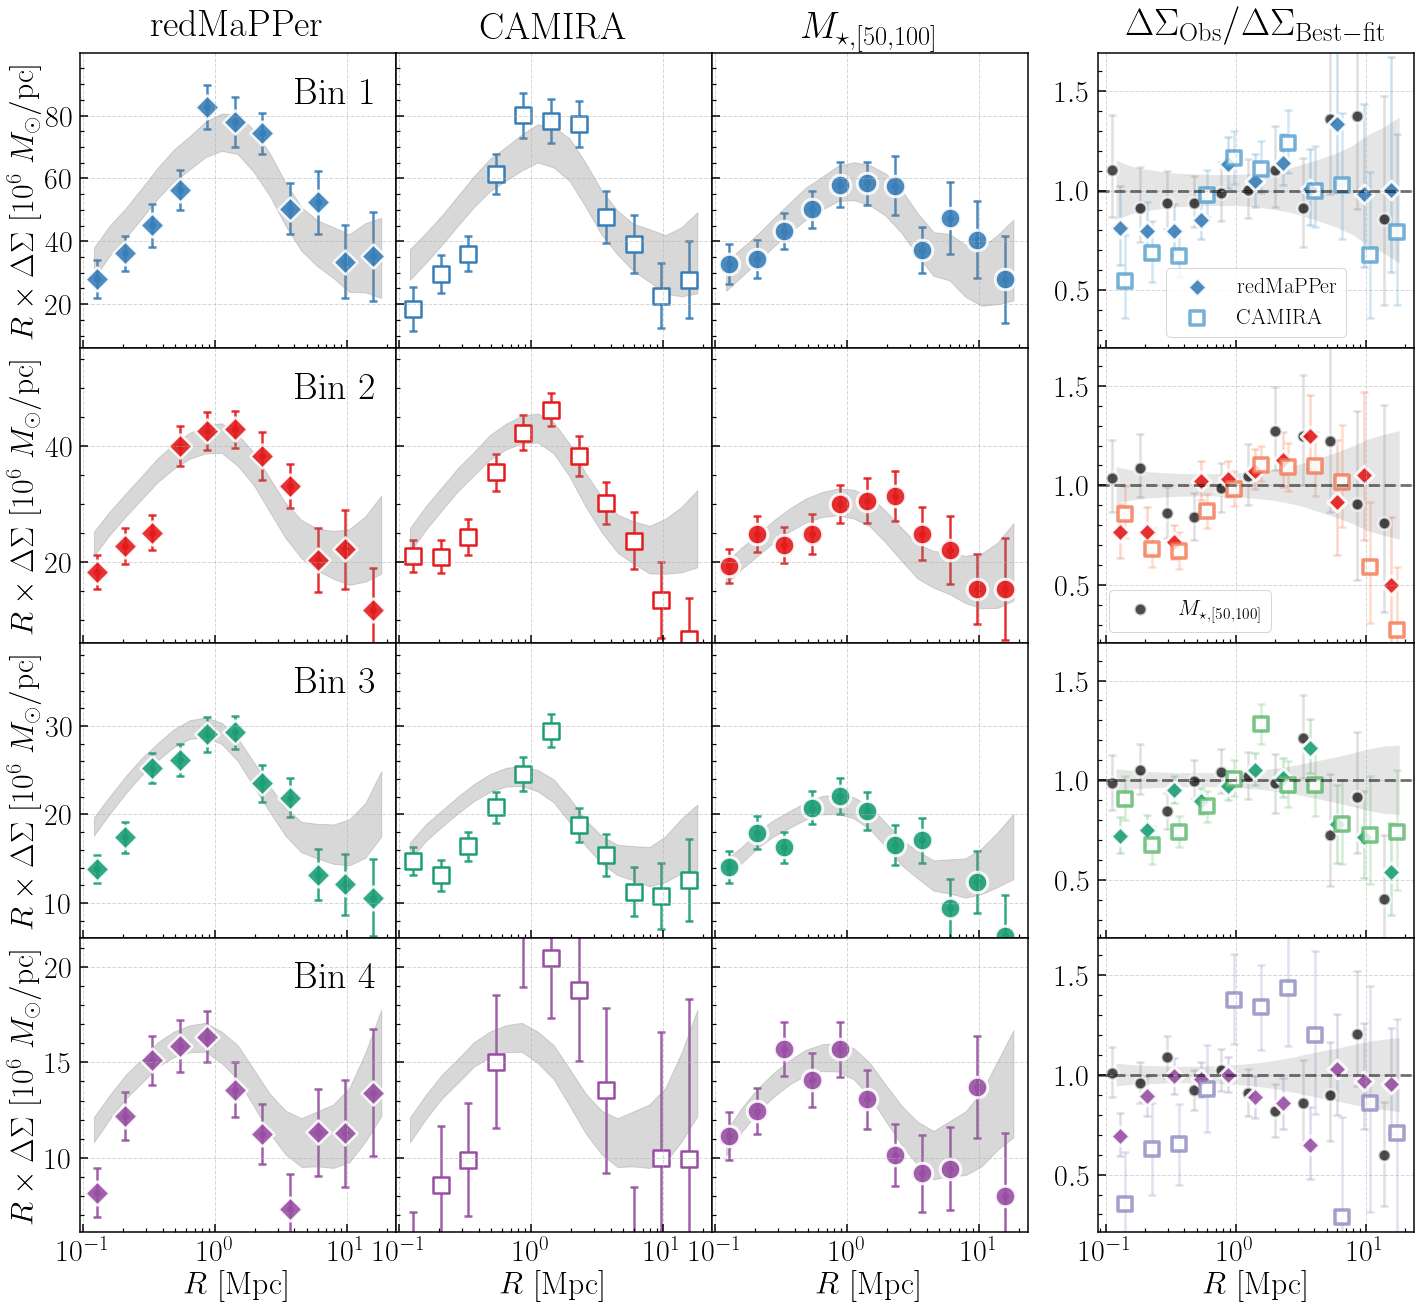

In [59]:
dsig_1 = topn_cluster['redm_hsc_lambda']
label_1 = r'$\rm redMaPPer$'
sub_1 = r'{\rm redM}'

dsig_2 = topn_cluster['cam_s16a_n_mem']
label_2 = r'$\rm CAMIRA$'
sub_2 = r'{\rm CAM}'

dsig_3 = topn_massive['logm_100_cen3']
label_3 = r'$M_{\star,\ 100\ \rm kpc}$'
sub_3 = r'{100\ \rm kpc}'

fig = compare_richness_mstar_model(dsig_1, dsig_2, dsig_3, sim_dsig, marker_3='o')

In [58]:
def compare_richness_mstar_model(
    dsig_1, dsig_2, dsig_3, sim_dsig, sig_type='bt',
    label_1=r'$\rm redMaPPer$', label_2=r'$\rm CAMIRA$', label_3=r'$M_{\star, [50,100]}$', 
    sub_1=r'{\rm redM}', sub_2=r'{\rm CAM}', sub_3=r'{[50, 100]}',
    cmap_list=None, color_bins=None, 
    marker_1='D', msize_1=290,
    marker_2='s', msize_2=250, 
    marker_3='H', msize_3=420):
    """Compare the Dsigma profiles."""

    def get_dsig_ratio(obs, ref, mod=None):
        """"""
        obs_rand = np.random.normal(
            loc=obs['dsigma'][0], scale=obs['dsig_err_{:s}'.format(sig_type)][0])

        if mod is not None:
            ref_rand = np.random.normal(
                loc=mod['dsig'], scale=(mod['dsig_err'] * err_factor))

            ref_inter = 10.0 ** (
                interpolate.interp1d(
                    mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)
            )
            return obs_rand / ref_inter
        else:
            ref_rand = np.random.normal(
                loc=ref['dsigma'][0], scale=obs['dsig_err_{:s}'.format(sig_type)][0])
            return obs_rand / ref_rand


    # Color maps and bins
    if cmap_list is None:
        cmap_list = [
            palettable.colorbrewer.sequential.Blues_7_r,
            palettable.colorbrewer.sequential.OrRd_7_r,
            palettable.colorbrewer.sequential.YlGn_7_r,
            palettable.colorbrewer.sequential.Purples_7_r]

    if color_bins is None:
        color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

    # Radius bin of the observed DSigma profiles
    r_mpc_obs = dsig_1.meta['r_mpc']

    # ---- Start the figure ---- #
    # Setup the figure
    n_col, n_bins = 4, len(dsig_1)
    fig_y = int(4 * n_bins + 2)
    left, right = 0.06, 0.98
    if n_bins == 4:
        bottom, top = 0.05, 0.96
    elif n_bins == 3:
        bottom, top = 0.075, 0.94
    elif n_bins == 2:
        bottom, top = 0.11, 0.92
    else:
        bottom, top = 0.13, 0.90
        
    x_space = 0.04
    x_size = (right - left - x_space * 1.05) / n_col
    y_size = (top - bottom) / n_bins
    
    fig = plt.figure(figsize=(20, fig_y))

    for bin_id in np.arange(len(dsig_1)) + 1:
        # Setup the three columns
        ax1 = fig.add_axes([left, top - y_size * bin_id, x_size, y_size])
        ax2 = fig.add_axes([left + x_size, top - y_size * bin_id, x_size, y_size])
        ax3 = fig.add_axes([left + x_size * 2, top - y_size * bin_id, x_size, y_size])
        ax4 = fig.add_axes([left + x_space + x_size * 3.04, top - y_size * bin_id, x_size, y_size])

        # Subplot title
        if bin_id == 1:
            ax1.set_title(label_1, fontsize=38, pad=18)
            ax2.set_title(label_2, fontsize=38, pad=15)
            ax3.set_title(label_3, fontsize=38, pad=15)
            ax4.set_title(r'$\Delta\Sigma_{\rm Obs}/\Delta\Sigma_{\rm Best-fit}$', 
                          fontsize=38, pad=18)

        # Color map
        cmap, color = cmap_list[bin_id - 1], color_bins[bin_id - 1]

        # MDPL halo mass information for this bin
        sim_dsig_bin = sim_dsig[sim_dsig['bin'] == bin_id - 1]

        # DSigma result for this bin
        dsig_1_bin = dsig_1[dsig_1['bin_id'] == bin_id]
        dsig_2_bin = dsig_2[dsig_2['bin_id'] == bin_id]
        dsig_3_bin = dsig_3[dsig_3['bin_id'] == bin_id]

        # Best fit DSigma profiles
        dsig_1_best = sim_dsig_bin[
            np.argmin(
                np.abs(sim_dsig_bin['scatter'] - dsig_1_bin['sig_med_{:s}'.format(sig_type)]))]
        dsig_2_best = sim_dsig_bin[
            np.argmin(
                np.abs(sim_dsig_bin['scatter'] - dsig_2_bin['sig_med_{:s}'.format(sig_type)]))]
        dsig_3_best = sim_dsig_bin[
            np.argmin(
                np.abs(sim_dsig_bin['scatter'] - dsig_3_bin['sig_med_{:s}'.format(sig_type)]))]

        if dsig_1_bin['sig_med_{:s}'.format(sig_type)] < 0.6:
            err_factor = 5.
        else:
            err_factor = 4.

        # Interpolated the reference model profile
        model_inter_1 = 10.0 ** (
            interpolate.interp1d(
                dsig_1_best['r_mpc'], np.log10(dsig_1_best['dsig']),
                fill_value='extrapolate')(r_mpc_obs)
        )
        
        model_inter_2 = 10.0 ** (
            interpolate.interp1d(
                dsig_2_best['r_mpc'], np.log10(dsig_2_best['dsig']),
                fill_value='extrapolate')(r_mpc_obs)
        )
        
        model_inter_3 = 10.0 ** (
            interpolate.interp1d(
                dsig_3_best['r_mpc'], np.log10(dsig_3_best['dsig']),
                fill_value='extrapolate')(r_mpc_obs)
        )
        
        ratio_sample_1 = [
            get_dsig_ratio(
                dsig_1_bin, dsig_1_bin, mod=dsig_1_best) for i in np.arange(2000)]
        ratio_1 = dsig_1_bin['dsigma'][0] / model_inter_1
        ratio_1_err_low = ratio_1 - np.nanpercentile(ratio_sample_1, 16, axis=0)
        ratio_1_err_upp = np.nanpercentile(ratio_sample_1, 84, axis=0) - ratio_1
        
        ratio_sample_2 = [
            get_dsig_ratio(
                dsig_2_bin, dsig_2_bin, mod=dsig_2_best) for i in np.arange(2000)]
        
        ratio_2 = dsig_2_bin['dsigma'][0] / model_inter_2
        ratio_2_err_low = ratio_2 - np.nanpercentile(ratio_sample_2, 16, axis=0)
        ratio_2_err_upp = np.nanpercentile(ratio_sample_2, 84, axis=0) - ratio_2
        
        ratio_sample_3 = [
            get_dsig_ratio(
                dsig_3_bin, dsig_3_bin, mod=dsig_3_best) for i in np.arange(2000)]
        
        ratio_3 = dsig_3_bin['dsigma'][0] / model_inter_3
        ratio_3_err_low = ratio_3 - np.nanpercentile(ratio_sample_3, 16, axis=0)
        ratio_3_err_upp = np.nanpercentile(ratio_sample_3, 84, axis=0) - ratio_3
        
        # ----- Plot 1: R x DSigma plot ----- #
        ax1.set_xscale("log", nonpositive='clip')

        ax1.fill_between(
            dsig_1_best['r_mpc'],
            dsig_1_best['r_mpc'] * (
                dsig_1_best['dsig'] - dsig_1_best['dsig_err'] * err_factor),
            dsig_1_best['r_mpc'] * (
                dsig_1_best['dsig'] + dsig_1_best['dsig_err'] * err_factor),
            alpha=0.3, edgecolor='grey', linewidth=1.0,
            label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

        ax1.errorbar(
            r_mpc_obs,
            r_mpc_obs * dsig_1_bin['dsigma'][0],
            yerr=(r_mpc_obs * dsig_1_bin['dsig_err_{:s}'.format(sig_type)][0]),
            ecolor=color, color=color, alpha=0.9, capsize=4, capthick=2.5, elinewidth=2.5,
            label='__no_label__', fmt='o', zorder=0)
        ax1.scatter(
            r_mpc_obs,
            r_mpc_obs * dsig_1_bin['dsigma'][0],
            s=msize_1, alpha=0.9, facecolor=color, edgecolor='w', marker=marker_1, 
            linewidth=2.5, label=label_1)

        y_max = np.max(
            [np.max(dsig_1_best['r_mpc'] * dsig_1_best['dsig']), 
             np.max(dsig_2_best['r_mpc'] * dsig_2_best['dsig']),
             np.max(dsig_3_best['r_mpc'] * dsig_3_best['dsig'])]) * 1.32
        
        if bin_id == 1:
            ax1.set_ylim(6.1, 99.9)
        else:
            ax1.set_ylim(6.1, y_max)

        # Bin ID
        _ = ax1.text(
            0.68, 0.83, r'$\rm Bin\ {:1d}$'.format(bin_id), fontsize=38, transform=ax1.transAxes)
        
        if bin_id == len(dsig_1):
            _ = ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)
        else:
            ax1.set_xticklabels([])
        _ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=32)
        
        
        # ----- Plot 2: R x DSigma plot ----- #
        ax2.set_xscale("log", nonpositive='clip')
        
        ax2.fill_between(
            dsig_2_best['r_mpc'],
            dsig_2_best['r_mpc'] * (
                dsig_2_best['dsig'] - dsig_2_best['dsig_err'] * err_factor),
            dsig_2_best['r_mpc'] * (
                dsig_2_best['dsig'] + dsig_2_best['dsig_err'] * err_factor),
            alpha=0.3, edgecolor='grey', linewidth=1.0,
            label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

        ax2.errorbar(
            r_mpc_obs,
            r_mpc_obs * dsig_2_bin['dsigma'][0],
            yerr=(r_mpc_obs * dsig_2_bin['dsig_err_{:s}'.format(sig_type)][0]),
            ecolor=color, color=color, alpha=0.9, capsize=4, capthick=2.5, elinewidth=2.5,
            label='__no_label__', fmt='o', zorder=0)
        ax2.scatter(
            r_mpc_obs,
            r_mpc_obs * dsig_2_bin['dsigma'][0],
            s=msize_2, alpha=1.0, facecolor='w', edgecolor=color, marker=marker_2, 
            linewidth=2.5, label=label_2)
        
        if bin_id == 1:
            ax2.set_ylim(6.1, 99.9)
        else:
            ax2.set_ylim(6.1, y_max)

        if bin_id == len(dsig_2):
            _ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)
        else:
            ax2.set_xticklabels([])
        
        ax2.set_yticklabels([])
        
        
        # ----- Plot 3: R x DSigma plot ----- #
        ax3.set_xscale("log", nonpositive='clip')
        
        ax3.fill_between(
            dsig_3_best['r_mpc'],
            dsig_3_best['r_mpc'] * (
                dsig_3_best['dsig'] - dsig_3_best['dsig_err'] * err_factor),
            dsig_3_best['r_mpc'] * (
                dsig_3_best['dsig'] + dsig_3_best['dsig_err'] * err_factor),
            alpha=0.3, edgecolor='grey', linewidth=1.0,
            label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

        ax3.errorbar(
            r_mpc_obs,
            r_mpc_obs * dsig_3_bin['dsigma'][0],
            yerr=(r_mpc_obs * dsig_3_bin['dsig_err_{:s}'.format(sig_type)][0]),
            ecolor=color, color=color, alpha=0.9, capsize=4, capthick=2.5, elinewidth=2.5,
            label='__no_label__', fmt='o', zorder=0)
        ax3.scatter(
            r_mpc_obs,
            r_mpc_obs * dsig_3_bin['dsigma'][0],
            s=msize_3, alpha=0.9, facecolor=color, edgecolor='w', marker=marker_3, 
            linewidth=3.0, label=label_3)
        
        if bin_id == 1:
            ax3.set_ylim(6.1, 99.9)
        else:
            ax3.set_ylim(6.1, y_max)

        if bin_id == len(dsig_3):
            _ = ax3.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)
        else:
            ax3.set_xticklabels([])
        
        ax3.set_yticklabels([])
        

        # ----- Plot 4: Ratio of DSigma plot ----- #
        ax4.set_xscale("log", nonpositive='clip')

        ax4.axhline(
            1.0, linewidth=3.0, alpha=0.5, color='k', linestyle='--', label='__no_label__', )

        # Uncertainty of the model
        ax4.fill_between(
            dsig_1_best['r_mpc'],
            1.0 - (dsig_1_best['dsig_err'] * err_factor / dsig_1_best['dsig']),
            1.0 + (dsig_1_best['dsig_err'] * err_factor / dsig_1_best['dsig']),
            alpha=0.2, edgecolor='none', linewidth=1.0, label='__no_label__',
            facecolor='grey', rasterized=True)
        
        label = label_3 if bin_id == 2 else None
        ax4.errorbar(
            r_mpc_obs * 0.88, ratio_3, yerr=[ratio_3_err_low, ratio_3_err_upp],
            ecolor='grey', color='w', alpha=0.25, capsize=4, capthick=2.5,
            elinewidth=2.5, label='__no_label__', fmt='o', zorder=0)
        ax4.scatter(
            r_mpc_obs * 0.88, ratio_3, s=150, alpha=0.7, facecolor='k', edgecolor='w',
            marker=marker_3, linewidth=2.5, label=label)
        
        ax4.errorbar(
            r_mpc_obs, ratio_1, yerr=[ratio_1_err_low, ratio_1_err_upp],
            ecolor=cmap.mpl_colormap(0.4), color='w', alpha=0.3, capsize=4, capthick=2.5,
            elinewidth=2.5, label='__no_label__', fmt='o', zorder=0)
        ax4.scatter(
            r_mpc_obs, ratio_1,
            s=180, alpha=0.9, facecolor=color, edgecolor='w',
            marker=marker_1, linewidth=3.0, label=(label_1 if bin_id == 1 else None))
        
        ax4.errorbar(
            r_mpc_obs * 1.1, ratio_2, yerr=[ratio_2_err_low, ratio_2_err_upp],
            ecolor=cmap.mpl_colormap(0.5), color='w', alpha=0.3, capsize=4, capthick=2.5,
            elinewidth=2.5, label='__no_label__', fmt='o', zorder=0)
        ax4.scatter(
            r_mpc_obs * 1.1, ratio_2,
            s=170, alpha=0.8, facecolor='w', edgecolor=cmap.mpl_colormap(0.4),
            marker=marker_2, linewidth=3.5, label=(label_2 if bin_id == 1 else None))
    
        ax4.set_ylim(0.21, 1.69)

        if np.max(ratio_2) < 1.2:
            y_pos = 0.85
        else:
            y_pos = 0.15

        if bin_id <= 2:
            ax4.legend(loc='best', fontsize=22)

        if bin_id == len(dsig_1):
            _ = ax4.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)
        else:
            ax4.set_xticklabels([])
            
        for tick in ax1.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax1.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

        for tick in ax2.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax2.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

        for tick in ax3.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax3.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)
            
        for tick in ax4.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax4.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

    return fig

/Users/song/Dropbox/work/submit/jianbing/jianbing/visual.py:475: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


Mean ratio in Bin 1: 0.869+/-0.145
Mean Mvir: 14.553 v.s. 14.517
Difference of Mvir in Bin 1: 0.036
Mean ratio in Bin 2: 0.928+/-0.108
Mean Mvir: 14.144 v.s. 14.161
Difference of Mvir in Bin 2: -0.016
Mean ratio in Bin 3: 0.765+/-0.078
Mean Mvir: 13.890 v.s. 13.693
Difference of Mvir in Bin 3: 0.197
Mean ratio in Bin 4: 0.959+/-0.231
Mean Mvir: 13.361 v.s. 13.361
Difference of Mvir in Bin 4: 0.000


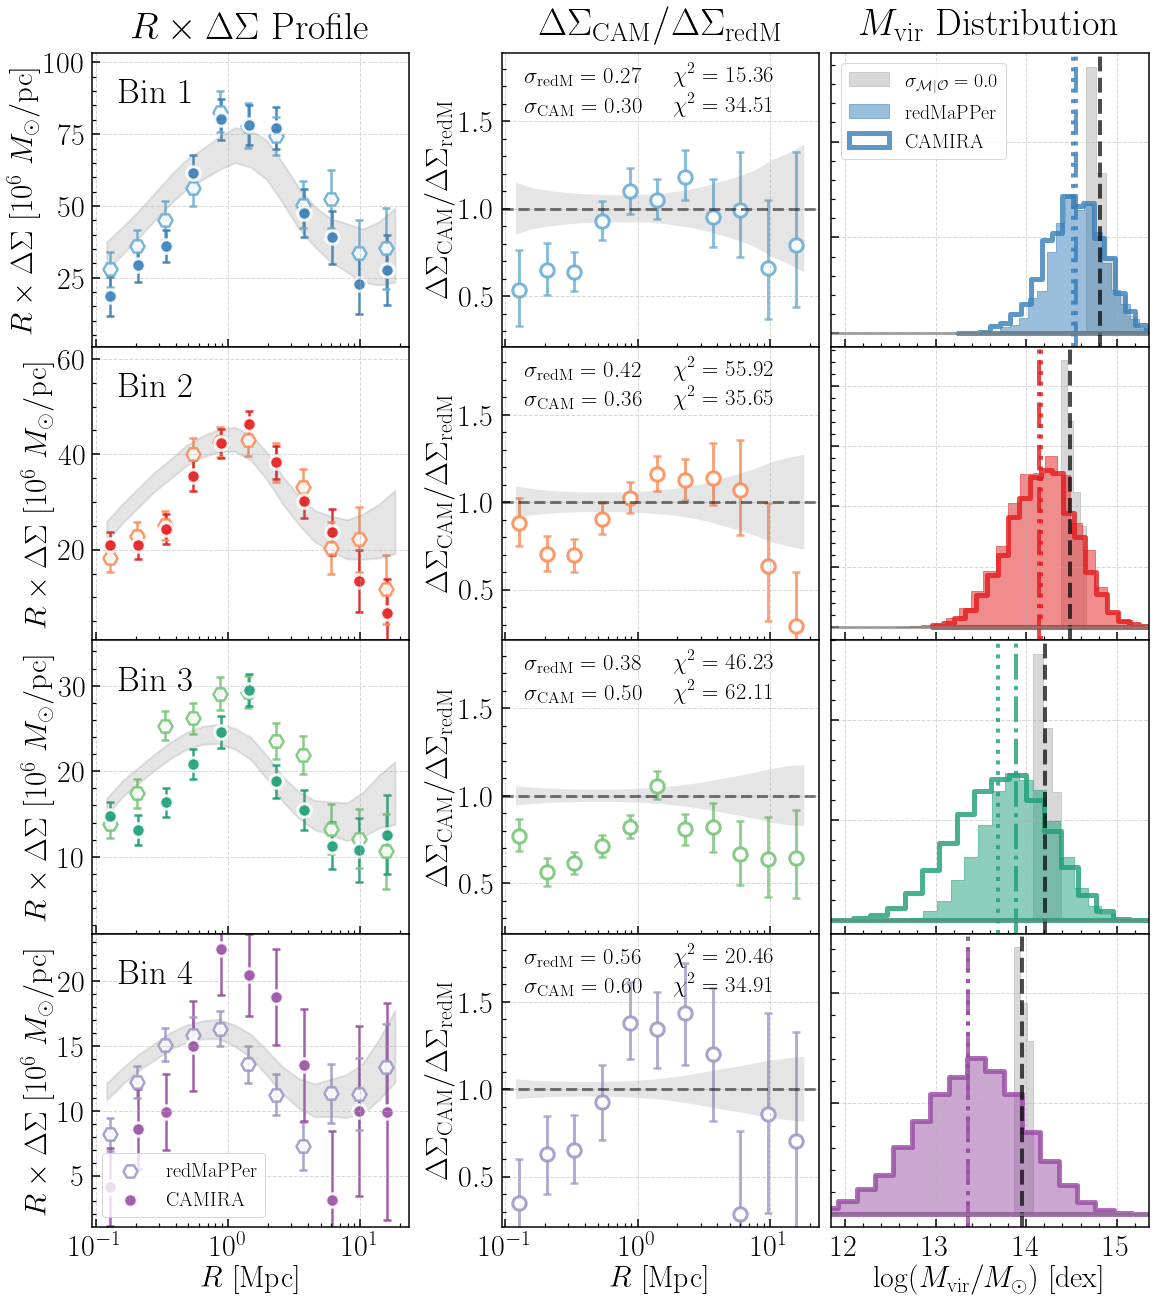

In [62]:
dsig_ref = topn_cluster['redm_hsc_lambda']
label_ref = r'$\rm redMaPPer$'
sub_ref = r'{\rm redM}'

dsig_cmp = topn_cluster['cam_s16a_n_mem']
label_cmp = r'$\rm CAMIRA$'
sub_cmp = r'{\rm CAM}'

fig = visual.compare_dsigma_profiles(
    dsig_ref, dsig_cmp, sim_dsig, sim_mhalo, sig_type='bt', compare_to_model=True,
    label_ref=label_ref, label_cmp=label_cmp, sub_ref=sub_ref, sub_cmp=sub_cmp,
    marker_ref='H', marker_cmp='o', msize_ref=200, msize_cmp=180,
    ratio_range=(0.21, 1.89), show_stats=True)

#### Compared to HSC redMaPPer catalog

<ipython-input-58-566934779293>:22: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


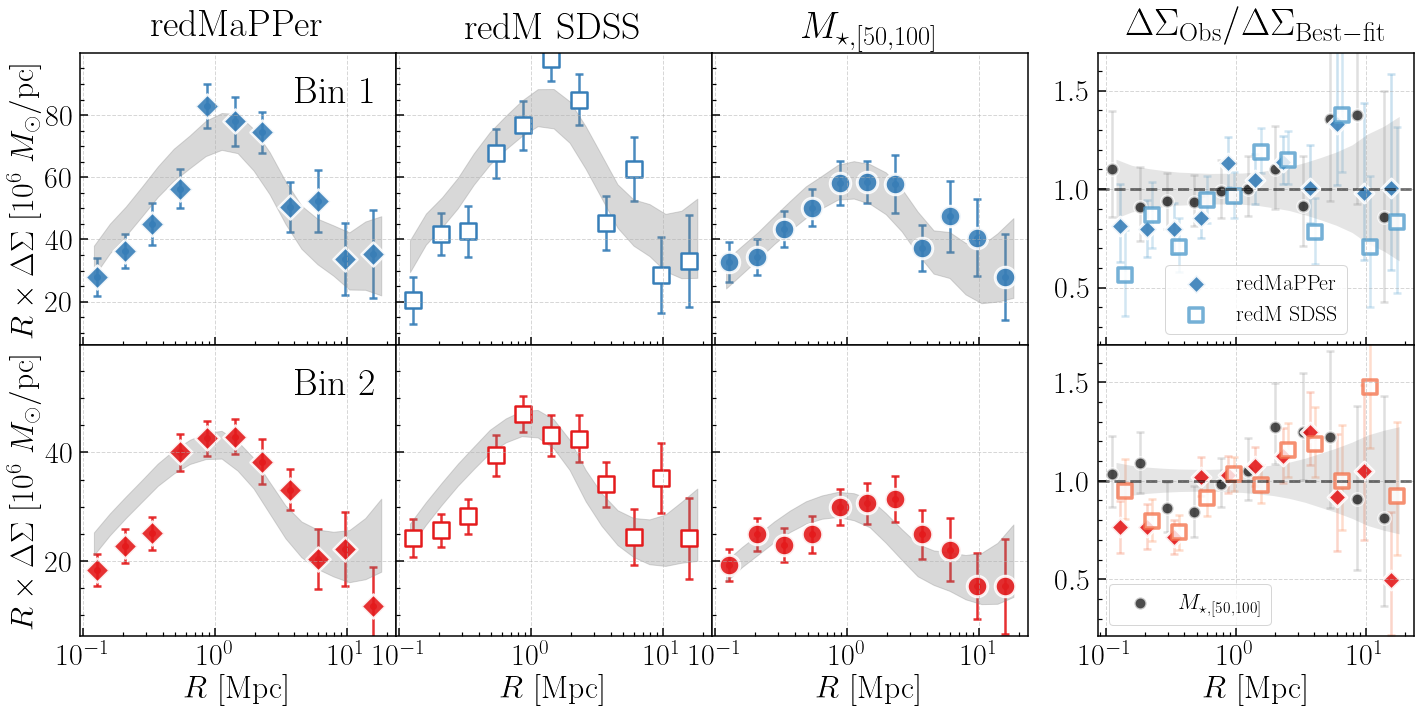

In [72]:
dsig_1 = topn_cluster['redm_hsc_lambda'][:2]
label_1 = r'$\rm red\ HSC$'
sub_1 = r'{\rm HSC}'

dsig_2 = topn_cluster['redm_sdss_lambda'][:2]
label_2 = r'$\rm redM\ SDSS$'
sub_2 = r'{\rm SDSS}'

dsig_3 = topn_massive['logm_100_cen3'][:2]
label_3 = r'$M_{\star,\ 100\ \rm kpc}$'
sub_3 = r'{100\ \rm kpc}'

fig = compare_richness_mstar_model(dsig_1, dsig_2, dsig_3, sim_dsig, marker_3='o', label_2=label_2)

Mean ratio in Bin 1: 0.797+/-0.133
Mean Mvir: 14.638 v.s. 14.517
Difference of Mvir in Bin 1: 0.121
Mean ratio in Bin 2: 0.851+/-0.099
Mean Mvir: 14.226 v.s. 14.161
Difference of Mvir in Bin 2: 0.065


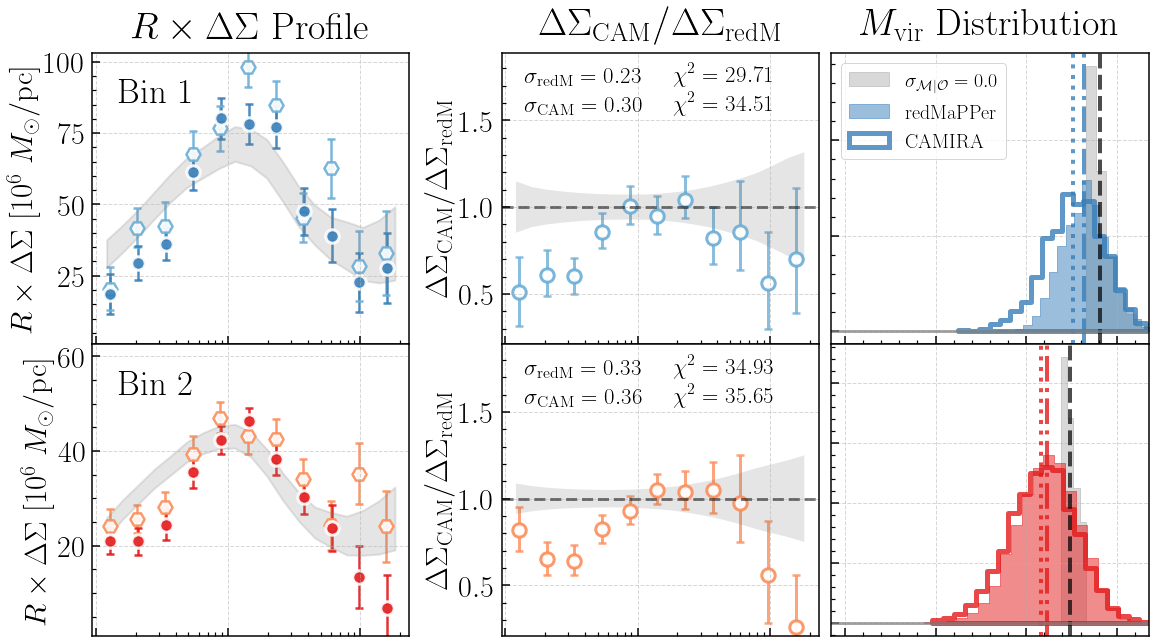

In [63]:
dsig_ref = topn_cluster['redm_sdss_lambda'][:2]
label_ref = r'$\rm redMaPPer$'
sub_ref = r'{\rm redM}'

dsig_cmp = topn_cluster['cam_s16a_n_mem'][:2]
label_cmp = r'$\rm CAMIRA$'
sub_cmp = r'{\rm CAM}'

fig = visual.compare_dsigma_profiles(
    dsig_ref, dsig_cmp, sim_dsig, sim_mhalo, sig_type='bt', compare_to_model=True,
    label_ref=label_ref, label_cmp=label_cmp, sub_ref=sub_ref, sub_cmp=sub_cmp,
    marker_ref='H', marker_cmp='o', msize_ref=200, msize_cmp=180,
    ratio_range=(0.21, 1.89), show_stats=True)